In [4]:
# import statements
%load_ext autoreload
%autoreload 2
%cd "../../"

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode


In [32]:

def closure(add_prior=True):
    return 0.5*(0.2*x*x + (2*y+1.0*x*x)**2)

def prob(x, y):
    return np.exp(-0.5*(0.2*x*x + (2*y+ 1.0*x*x)**2))



def get_multimodal_fns(x,y, mixture=(0.5,0.5), means=([-1,-1], [1,1]),
                       sigmas=([1,0.5], [0.5,1]), corr=(0.5,-0.5)):


    def prob_multimodal(x__, y__):
        prob = 0.
        for i, w in enumerate(mixture):    
            x_ = (x__ - means[i][0])/sigmas[i][0]
            y_ = (y__ - means[i][1])/sigmas[i][1]
            if 'torch' in type(x__).__module__:
                prob += w*torch.exp(-(x_**2 + y_**2 - 2*corr[i]*x_*y_)/(2*(1-corr[i]**2)))/(sigmas[i][0]*sigmas[i][1]*np.sqrt(1-corr[i]**2))    
            elif 'numpy' in type(x__).__module__:
                prob += w*np.exp(-(x_**2 + y_**2 - 2*corr[i]*x_*y_)/(2*(1-corr[i]**2)))/(sigmas[i][0]*sigmas[i][1]*np.sqrt(1-corr[i]**2))        
        return prob

    def closure_multimodal(add_prior=True):
        return -torch.log(prob_multimodal(x, y))


    def plot_contours_multimodal(ax):
        
        X = np.linspace(-2*max([sigmas[i][0] for i in range(len(sigmas))]) + min([means[i][0] for i in range(len(means))]),
                        2*max([sigmas[i][0] for i in range(len(sigmas))]) + max([means[i][0] for i in range(len(means))]), 1000)
        Y = np.linspace(-2*max([sigmas[i][1] for i in range(len(sigmas))]) + min([means[i][1] for i in range(len(means))]),
                        2*max([sigmas[i][1] for i in range(len(sigmas))]) + max([means[i][1] for i in range(len(means))]), 1000)

        X, Y = np.meshgrid(X, Y)

        Z = prob_multimodal(X, Y)
        cmap = cm.get_cmap('binary')
        cmap.set_under(color='w')
        ax.contourf(X, Y, Z, cmap=cmap, alpha=0.5, extend='both')
        ax.scatter([mean[0] for mean in means], [mean[1] for mean in means], color='g', s=3)
        
        
    return closure_multimodal, prob_multimodal, plot_contours_multimodal


def get_gauss_fns(sigma1, sigma2, corr):

    def closure_gauss(add_prior=True):
        x_ = (x-2)/sigma1
        y_ = (y-4)/sigma2
        return (x_**2 + y_**2 - 2*corr*x_*y_)#/(2*(1-corr**2))    
    
    def prob_gauss(x,y):
        x_ = (x-2)/sigma1
        y_ = (y-4)/sigma2
        return np.exp(-(x_**2 + y_**2 - 2*corr*x_*y_)    )#/(2*(1-corr**2)))    

    def plot_contours_gauss(ax):    
        X = np.linspace(-max(sigma1*4,1)+2, max(1,sigma1*4)+2, 1000)
        Y = np.linspace(-max(1,sigma2*4)+4, max(1,sigma2*4)+4, 1000)
        
        X, Y = np.meshgrid(X, Y)

        Z = prob_gauss(X, Y)
        ax.contour(X, Y, Z, zorder=-10)

#     return closure_gauss, prob_gauss, plot_contours_gauss

x = torch.nn.Parameter(torch.randn([1]))
y = torch.nn.Parameter(torch.randn([1]))

closure, prob, plot_contours = get_multimodal_fns(x, y, mixture=[1./36.]*25,
                                                 means=[[2.*(i+1)-5., 2.*(j+1)-5.] for i in range(5) for j in range(5)],
                                                 sigmas=[[0.4,0.4] for i in range(25)],
                                                 corr = [0.]*25)

# def closure(add_prior=True):
#     return 0.5*(0.03*(x-2)**2 + 1*(y-4)**2)

# def prob(x, y):
#     return 0.5*(0.03*(x-2)**2 + 1*(y-4)**2)

# def closure(add_prior=True):
#     return 0.5*(1*(x-2)**2 + 1*(y-4)**2)

# def prob(x, y):
#     return 0.5*(1*(x-2)**2 + 1*(y-4)**2)

# def plot_contours(ax):
#     X = np.linspace(-6, 6, 1000)
#     Y = np.linspace(-10, 2, 3000)
#     X, Y = np.meshgrid(X, Y)

#     Z = prob(X, Y)
#     my_cmap = cm.get_cmap("binary")
#     my_cmap.set_over('k')
#     my_cmap.set_under('w')
#     sns.set(context="notebook", style="whitegrid",
#         rc={"axes.axisbelow": False,"axes.grid": False})
#     ax.contourf(X,Y,Z,cmap=my_cmap,vmin=0.01,vmax=0.99, alpha=0.5, extend='both')
# #     ax.contour(X, Y, Z, zorder=-10)

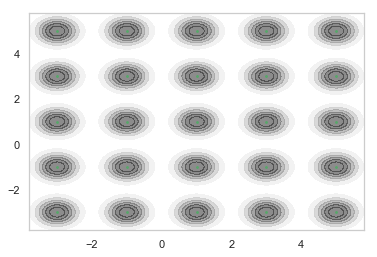

In [33]:
fig, ax = plt.subplots()
plot_contours(ax)

In [19]:

from samplers.metrics import *


def hess_closure():
    hess = eval_full_hessian(torch.autograd.grad(closure(), params, create_graph=True), params)
#     plt.figure()
#     plt.imshow(hess.clone().detach().numpy())
#     plt.colorbar()
    return hess

# metric = SoftAbsMetric(closure=hess_closure, softabs_coeff=10)
# metric = HessianMetric(closure=hess_closure)
# metric = IdentityMetric(size=l)

In [118]:
x = torch.nn.Parameter(torch.randn([1]))
y = torch.nn.Parameter(torch.randn([1]))

params = [x, y]


from samplers.langevin import MALA, MMALA, SGLD, pSGLD, HAMCMC, HAMCMC2, HAMCMC3, HAMCMC4
from samplers.hamiltonian import aSGHMC

# sampler = MALA(params, lr=5e-2, add_noise=True)
# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=10000, print_loss=True)

# sampler = SGLD(params, lr0=0.3, lr_gamma=0.51, lr_t0=10, lr_alpha=0.01, lambda_=1e-5, alpha=0.95,)
# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=10000, print_loss=True)

# sampler = pSGLD(params, lr0=0.1, lr_gamma=0.51, lr_t0=10, lr_alpha=0.01, lambda_=1e-8, alpha=0.98,)
# chain, logp_array = sampler.sample(closure, burn_in=200, num_samples=1000, print_loss=True)

# sampler = HAMCMC(params, lr0=0.03, lr_gamma=0.51, lr_t0=1, lr_alpha=0.01, trust_reg=0, memory=1, H_gamma=1e-0, cholesky_factor=1e-1)
# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=10000, print_loss=True, use_old_lbfgs=True, add_noise=False)

# sampler = HAMCMC2(params, lr0=0.01, lr_gamma=0.51, lr_t0=100, lr_alpha=0.1, trust_reg=1e0, memory=3, H_gamma=1e0, cholesky_factor=1e-1)
# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=10000, print_loss=True, use_old_lbfgs=True, add_noise=False)

# sampler = HAMCMC3(params, lr0=0.001, lr_gamma=0.51, lr_t0=100, lr_alpha=0.1, trust_reg=1e0, memory=3, H_gamma=1e0, cholesky_factor=1e-1)
# chain, logp_array = sampler.sample(closure, burn_in=200, num_samples=1000, print_loss=True, use_old_lbfgs=True, add_noise=False)

# sampler = HAMCMC4(params, lr0=0.01, lr_gamma=0.51, lr_t0=100, lr_alpha=0.1, trust_reg=1e1, memory=3, H_gamma=1e-2, cholesky_factor=1e-1)
# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=10000, print_loss=True, use_old_lbfgs=False, add_noise=True)

sampler = aSGHMC(params, lr=0.1, add_noise=True, mom_decay=5e-2, lambda_=1e-8)
chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=10000, print_loss=True, resample_mom_every=100000)


<class 'dict'>
Burn-in phase started
Burn-in iter 0001 | loss 23.687901
Burn-in iter 0002 | loss 22.826485
Burn-in iter 0003 | loss 21.681971
Burn-in iter 0004 | loss 20.320171
Burn-in iter 0005 | loss 18.800262
Burn-in iter 0006 | loss 17.175985
Burn-in iter 0007 | loss 15.496176
Burn-in iter 0008 | loss 13.804714
Burn-in iter 0009 | loss 12.140183
Burn-in iter 0010 | loss 10.535526
Burn-in iter 0011 | loss 9.025641
Burn-in iter 0012 | loss 7.652349
Burn-in iter 0013 | loss 6.357727
Burn-in iter 0014 | loss 5.233752
Burn-in iter 0015 | loss 4.219951
Burn-in iter 0016 | loss 3.299874
Burn-in iter 0017 | loss 2.521735
Burn-in iter 0018 | loss 1.844438
Burn-in iter 0019 | loss 1.299702
Burn-in iter 0020 | loss 0.906847
Burn-in iter 0021 | loss 0.587628
Burn-in iter 0022 | loss 0.378018
Burn-in iter 0023 | loss 0.239288
Burn-in iter 0024 | loss 0.209296
Burn-in iter 0025 | loss 0.160504
Burn-in iter 0026 | loss 0.117765
Burn-in iter 0027 | loss 0.090716
Burn-in iter 0028 | loss 0.124060
B

Burn-in iter 0342 | loss 1.931315
Burn-in iter 0343 | loss 1.795118
Burn-in iter 0344 | loss 1.624101
Burn-in iter 0345 | loss 1.559316
Burn-in iter 0346 | loss 1.534823
Burn-in iter 0347 | loss 1.601720
Burn-in iter 0348 | loss 1.741254
Burn-in iter 0349 | loss 1.759526
Burn-in iter 0350 | loss 1.590453
Burn-in iter 0351 | loss 1.465042
Burn-in iter 0352 | loss 1.499166
Burn-in iter 0353 | loss 1.681383
Burn-in iter 0354 | loss 1.819269
Burn-in iter 0355 | loss 1.765024
Burn-in iter 0356 | loss 1.505614
Burn-in iter 0357 | loss 1.344942
Burn-in iter 0358 | loss 1.370857
Burn-in iter 0359 | loss 1.800219
Burn-in iter 0360 | loss 2.526450
Burn-in iter 0361 | loss 3.034712
Burn-in iter 0362 | loss 3.456635
Burn-in iter 0363 | loss 3.619103
Burn-in iter 0364 | loss 3.545598
Burn-in iter 0365 | loss 3.284066
Burn-in iter 0366 | loss 2.874121
Burn-in iter 0367 | loss 2.322680
Burn-in iter 0368 | loss 1.842762
Burn-in iter 0369 | loss 1.502474
Burn-in iter 0370 | loss 1.313098
Burn-in iter 0

Burn-in iter 0684 | loss 2.581604
Burn-in iter 0685 | loss 2.337442
Burn-in iter 0686 | loss 2.058125
Burn-in iter 0687 | loss 1.912541
Burn-in iter 0688 | loss 1.816855
Burn-in iter 0689 | loss 1.789353
Burn-in iter 0690 | loss 1.846725
Burn-in iter 0691 | loss 2.034122
Burn-in iter 0692 | loss 2.215047
Burn-in iter 0693 | loss 2.273646
Burn-in iter 0694 | loss 2.184679
Burn-in iter 0695 | loss 2.029268
Burn-in iter 0696 | loss 1.890404
Burn-in iter 0697 | loss 1.867288
Burn-in iter 0698 | loss 1.926960
Burn-in iter 0699 | loss 2.017491
Burn-in iter 0700 | loss 2.059772
Burn-in iter 0701 | loss 1.995177
Burn-in iter 0702 | loss 1.972119
Burn-in iter 0703 | loss 1.925588
Burn-in iter 0704 | loss 1.888136
Burn-in iter 0705 | loss 1.900613
Burn-in iter 0706 | loss 1.861009
Burn-in iter 0707 | loss 1.834997
Burn-in iter 0708 | loss 1.817526
Burn-in iter 0709 | loss 1.816815
Burn-in iter 0710 | loss 1.819997
Burn-in iter 0711 | loss 1.827992
Burn-in iter 0712 | loss 1.853533
Burn-in iter 0

Burn-in iter 1082 | loss 0.342403
Burn-in iter 1083 | loss 0.165037
Burn-in iter 1084 | loss 0.084569
Burn-in iter 1085 | loss 0.152459
Burn-in iter 1086 | loss 0.349823
Burn-in iter 1087 | loss 0.766735
Burn-in iter 1088 | loss 1.088192
Burn-in iter 1089 | loss 1.414493
Burn-in iter 1090 | loss 1.589171
Burn-in iter 1091 | loss 1.769214
Burn-in iter 1092 | loss 1.973697
Burn-in iter 1093 | loss 1.986438
Burn-in iter 1094 | loss 1.834928
Burn-in iter 1095 | loss 1.320923
Burn-in iter 1096 | loss 0.907090
Burn-in iter 1097 | loss 0.554423
Burn-in iter 1098 | loss 0.274221
Burn-in iter 1099 | loss 0.129816
Burn-in iter 1100 | loss 0.079882
Burn-in iter 1101 | loss 0.106202
Burn-in iter 1102 | loss 0.215927
Burn-in iter 1103 | loss 0.397440
Burn-in iter 1104 | loss 0.532913
Burn-in iter 1105 | loss 0.617642
Burn-in iter 1106 | loss 0.700878
Burn-in iter 1107 | loss 0.768098
Burn-in iter 1108 | loss 0.817875
Burn-in iter 1109 | loss 0.984481
Burn-in iter 1110 | loss 1.030643
Burn-in iter 1

Burn-in iter 1436 | loss 1.381256
Burn-in iter 1437 | loss 1.349490
Burn-in iter 1438 | loss 1.358162
Burn-in iter 1439 | loss 1.359558
Burn-in iter 1440 | loss 1.405767
Burn-in iter 1441 | loss 1.486418
Burn-in iter 1442 | loss 1.591699
Burn-in iter 1443 | loss 1.616791
Burn-in iter 1444 | loss 1.467527
Burn-in iter 1445 | loss 1.449471
Burn-in iter 1446 | loss 1.889455
Burn-in iter 1447 | loss 2.256812
Burn-in iter 1448 | loss 2.283477
Burn-in iter 1449 | loss 2.175619
Burn-in iter 1450 | loss 1.886399
Burn-in iter 1451 | loss 1.568368
Burn-in iter 1452 | loss 1.432968
Burn-in iter 1453 | loss 1.684382
Burn-in iter 1454 | loss 1.954848
Burn-in iter 1455 | loss 1.838809
Burn-in iter 1456 | loss 1.548765
Burn-in iter 1457 | loss 1.443909
Burn-in iter 1458 | loss 1.563644
Burn-in iter 1459 | loss 1.948032
Burn-in iter 1460 | loss 2.020060
Burn-in iter 1461 | loss 1.988353
Burn-in iter 1462 | loss 1.779119
Burn-in iter 1463 | loss 1.538484
Burn-in iter 1464 | loss 1.667013
Burn-in iter 1

Burn-in iter 1790 | loss 3.819417
Burn-in iter 1791 | loss 3.972374
Burn-in iter 1792 | loss 4.010935
Burn-in iter 1793 | loss 3.946038
Burn-in iter 1794 | loss 3.866350
Burn-in iter 1795 | loss 3.853534
Burn-in iter 1796 | loss 3.891258
Burn-in iter 1797 | loss 3.957824
Burn-in iter 1798 | loss 3.951422
Burn-in iter 1799 | loss 3.997499
Burn-in iter 1800 | loss 3.946521
Burn-in iter 1801 | loss 3.926077
Burn-in iter 1802 | loss 3.903209
Burn-in iter 1803 | loss 3.950450
Burn-in iter 1804 | loss 4.027301
Burn-in iter 1805 | loss 4.081656
Burn-in iter 1806 | loss 4.043478
Burn-in iter 1807 | loss 3.991034
Burn-in iter 1808 | loss 3.953678
Burn-in iter 1809 | loss 3.974995
Burn-in iter 1810 | loss 4.087873
Burn-in iter 1811 | loss 4.138033
Burn-in iter 1812 | loss 4.025725
Burn-in iter 1813 | loss 3.959567
Burn-in iter 1814 | loss 3.974260
Burn-in iter 1815 | loss 4.003537
Burn-in iter 1816 | loss 4.018151
Burn-in iter 1817 | loss 4.021505
Burn-in iter 1818 | loss 3.919971
Burn-in iter 1

Sample iter 0154 | loss 3.303700
Sample iter 0155 | loss 3.272333
Sample iter 0156 | loss 3.255080
Sample iter 0157 | loss 3.246489
Sample iter 0158 | loss 3.243403
Sample iter 0159 | loss 3.324234
Sample iter 0160 | loss 3.358180
Sample iter 0161 | loss 3.309505
Sample iter 0162 | loss 3.230366
Sample iter 0163 | loss 3.131103
Sample iter 0164 | loss 3.106067
Sample iter 0165 | loss 3.122630
Sample iter 0166 | loss 3.115362
Sample iter 0167 | loss 3.061522
Sample iter 0168 | loss 3.019082
Sample iter 0169 | loss 2.999934
Sample iter 0170 | loss 2.985931
Sample iter 0171 | loss 2.959151
Sample iter 0172 | loss 2.925197
Sample iter 0173 | loss 2.905320
Sample iter 0174 | loss 2.901315
Sample iter 0175 | loss 2.926723
Sample iter 0176 | loss 2.996261
Sample iter 0177 | loss 3.090756
Sample iter 0178 | loss 3.088389
Sample iter 0179 | loss 3.024976
Sample iter 0180 | loss 2.911288
Sample iter 0181 | loss 2.802878
Sample iter 0182 | loss 2.772240
Sample iter 0183 | loss 2.832025
Sample ite

Sample iter 0555 | loss 0.785503
Sample iter 0556 | loss 0.695513
Sample iter 0557 | loss 0.658301
Sample iter 0558 | loss 0.698213
Sample iter 0559 | loss 0.903011
Sample iter 0560 | loss 1.201823
Sample iter 0561 | loss 1.541422
Sample iter 0562 | loss 1.770650
Sample iter 0563 | loss 1.792060
Sample iter 0564 | loss 1.657420
Sample iter 0565 | loss 1.397499
Sample iter 0566 | loss 1.093249
Sample iter 0567 | loss 0.861972
Sample iter 0568 | loss 0.722115
Sample iter 0569 | loss 0.716697
Sample iter 0570 | loss 0.786834
Sample iter 0571 | loss 0.867162
Sample iter 0572 | loss 0.941154
Sample iter 0573 | loss 1.022577
Sample iter 0574 | loss 1.085771
Sample iter 0575 | loss 1.024815
Sample iter 0576 | loss 0.959978
Sample iter 0577 | loss 0.896310
Sample iter 0578 | loss 0.833018
Sample iter 0579 | loss 0.788387
Sample iter 0580 | loss 0.753910
Sample iter 0581 | loss 0.726314
Sample iter 0582 | loss 0.724963
Sample iter 0583 | loss 0.739048
Sample iter 0584 | loss 0.779081
Sample ite

Sample iter 0957 | loss 1.084860
Sample iter 0958 | loss 0.987416
Sample iter 0959 | loss 0.937428
Sample iter 0960 | loss 0.878360
Sample iter 0961 | loss 0.849846
Sample iter 0962 | loss 0.782590
Sample iter 0963 | loss 0.706472
Sample iter 0964 | loss 0.630927
Sample iter 0965 | loss 0.562520
Sample iter 0966 | loss 0.523717
Sample iter 0967 | loss 0.494880
Sample iter 0968 | loss 0.485529
Sample iter 0969 | loss 0.504657
Sample iter 0970 | loss 0.490630
Sample iter 0971 | loss 0.487502
Sample iter 0972 | loss 0.495492
Sample iter 0973 | loss 0.462902
Sample iter 0974 | loss 0.436925
Sample iter 0975 | loss 0.423271
Sample iter 0976 | loss 0.409325
Sample iter 0977 | loss 0.419195
Sample iter 0978 | loss 0.422389
Sample iter 0979 | loss 0.397939
Sample iter 0980 | loss 0.403322
Sample iter 0981 | loss 0.369766
Sample iter 0982 | loss 0.321671
Sample iter 0983 | loss 0.296302
Sample iter 0984 | loss 0.288316
Sample iter 0985 | loss 0.303182
Sample iter 0986 | loss 0.321834
Sample ite

Sample iter 1358 | loss 0.881754
Sample iter 1359 | loss 0.822977
Sample iter 1360 | loss 0.783164
Sample iter 1361 | loss 0.749461
Sample iter 1362 | loss 0.763566
Sample iter 1363 | loss 0.778570
Sample iter 1364 | loss 0.789898
Sample iter 1365 | loss 0.832848
Sample iter 1366 | loss 0.880469
Sample iter 1367 | loss 0.955588
Sample iter 1368 | loss 0.979671
Sample iter 1369 | loss 1.008689
Sample iter 1370 | loss 1.010377
Sample iter 1371 | loss 0.991289
Sample iter 1372 | loss 1.026037
Sample iter 1373 | loss 1.040005
Sample iter 1374 | loss 0.996281
Sample iter 1375 | loss 0.939946
Sample iter 1376 | loss 0.925340
Sample iter 1377 | loss 0.933497
Sample iter 1378 | loss 0.970504
Sample iter 1379 | loss 1.011490
Sample iter 1380 | loss 1.038576
Sample iter 1381 | loss 1.029496
Sample iter 1382 | loss 1.023294
Sample iter 1383 | loss 0.972460
Sample iter 1384 | loss 0.943424
Sample iter 1385 | loss 0.957022
Sample iter 1386 | loss 1.002106
Sample iter 1387 | loss 1.023323
Sample ite

Sample iter 1760 | loss 0.061882
Sample iter 1761 | loss 0.074632
Sample iter 1762 | loss 0.095747
Sample iter 1763 | loss 0.077638
Sample iter 1764 | loss 0.079127
Sample iter 1765 | loss 0.073336
Sample iter 1766 | loss 0.059332
Sample iter 1767 | loss 0.050869
Sample iter 1768 | loss 0.041725
Sample iter 1769 | loss 0.034249
Sample iter 1770 | loss 0.038014
Sample iter 1771 | loss 0.043509
Sample iter 1772 | loss 0.049272
Sample iter 1773 | loss 0.042624
Sample iter 1774 | loss 0.035876
Sample iter 1775 | loss 0.048772
Sample iter 1776 | loss 0.043676
Sample iter 1777 | loss 0.034528
Sample iter 1778 | loss 0.025026
Sample iter 1779 | loss 0.030801
Sample iter 1780 | loss 0.029514
Sample iter 1781 | loss 0.025371
Sample iter 1782 | loss 0.023656
Sample iter 1783 | loss 0.018482
Sample iter 1784 | loss 0.008300
Sample iter 1785 | loss 0.004182
Sample iter 1786 | loss 0.021391
Sample iter 1787 | loss 0.057721
Sample iter 1788 | loss 0.113917
Sample iter 1789 | loss 0.158737
Sample ite

Sample iter 2162 | loss 0.359978
Sample iter 2163 | loss 0.333856
Sample iter 2164 | loss 0.319005
Sample iter 2165 | loss 0.335018
Sample iter 2166 | loss 0.368728
Sample iter 2167 | loss 0.419221
Sample iter 2168 | loss 0.451066
Sample iter 2169 | loss 0.499695
Sample iter 2170 | loss 0.489415
Sample iter 2171 | loss 0.434540
Sample iter 2172 | loss 0.386618
Sample iter 2173 | loss 0.327144
Sample iter 2174 | loss 0.318920
Sample iter 2175 | loss 0.348779
Sample iter 2176 | loss 0.396360
Sample iter 2177 | loss 0.482660
Sample iter 2178 | loss 0.618892
Sample iter 2179 | loss 0.777003
Sample iter 2180 | loss 1.064860
Sample iter 2181 | loss 1.345613
Sample iter 2182 | loss 1.527211
Sample iter 2183 | loss 1.610763
Sample iter 2184 | loss 1.650304
Sample iter 2185 | loss 1.375563
Sample iter 2186 | loss 0.980487
Sample iter 2187 | loss 0.628044
Sample iter 2188 | loss 0.509125
Sample iter 2189 | loss 0.394748
Sample iter 2190 | loss 0.327564
Sample iter 2191 | loss 0.323651
Sample ite

Sample iter 2565 | loss 0.160957
Sample iter 2566 | loss 0.157101
Sample iter 2567 | loss 0.152729
Sample iter 2568 | loss 0.149754
Sample iter 2569 | loss 0.146404
Sample iter 2570 | loss 0.148761
Sample iter 2571 | loss 0.159750
Sample iter 2572 | loss 0.164915
Sample iter 2573 | loss 0.184755
Sample iter 2574 | loss 0.213943
Sample iter 2575 | loss 0.253833
Sample iter 2576 | loss 0.281076
Sample iter 2577 | loss 0.355763
Sample iter 2578 | loss 0.424665
Sample iter 2579 | loss 0.449498
Sample iter 2580 | loss 0.464599
Sample iter 2581 | loss 0.418051
Sample iter 2582 | loss 0.402733
Sample iter 2583 | loss 0.409921
Sample iter 2584 | loss 0.378783
Sample iter 2585 | loss 0.312874
Sample iter 2586 | loss 0.248702
Sample iter 2587 | loss 0.141601
Sample iter 2588 | loss 0.110078
Sample iter 2589 | loss 0.127456
Sample iter 2590 | loss 0.146881
Sample iter 2591 | loss 0.166710
Sample iter 2592 | loss 0.181915
Sample iter 2593 | loss 0.215936
Sample iter 2594 | loss 0.256859
Sample ite

Sample iter 2969 | loss 0.925466
Sample iter 2970 | loss 0.809172
Sample iter 2971 | loss 0.733223
Sample iter 2972 | loss 0.552513
Sample iter 2973 | loss 0.410141
Sample iter 2974 | loss 0.327921
Sample iter 2975 | loss 0.226629
Sample iter 2976 | loss 0.126263
Sample iter 2977 | loss 0.066962
Sample iter 2978 | loss 0.028290
Sample iter 2979 | loss 0.003026
Sample iter 2980 | loss 0.000847
Sample iter 2981 | loss 0.005681
Sample iter 2982 | loss 0.026180
Sample iter 2983 | loss 0.049024
Sample iter 2984 | loss 0.078683
Sample iter 2985 | loss 0.072994
Sample iter 2986 | loss 0.064217
Sample iter 2987 | loss 0.041238
Sample iter 2988 | loss 0.035296
Sample iter 2989 | loss 0.013621
Sample iter 2990 | loss 0.002635
Sample iter 2991 | loss 0.001105
Sample iter 2992 | loss 0.005571
Sample iter 2993 | loss 0.005093
Sample iter 2994 | loss 0.015501
Sample iter 2995 | loss 0.023112
Sample iter 2996 | loss 0.027567
Sample iter 2997 | loss 0.037902
Sample iter 2998 | loss 0.049848
Sample ite

Sample iter 3373 | loss 0.187725
Sample iter 3374 | loss 0.229511
Sample iter 3375 | loss 0.290166
Sample iter 3376 | loss 0.347158
Sample iter 3377 | loss 0.414169
Sample iter 3378 | loss 0.444095
Sample iter 3379 | loss 0.408938
Sample iter 3380 | loss 0.359098
Sample iter 3381 | loss 0.285460
Sample iter 3382 | loss 0.223097
Sample iter 3383 | loss 0.172564
Sample iter 3384 | loss 0.178166
Sample iter 3385 | loss 0.211235
Sample iter 3386 | loss 0.278502
Sample iter 3387 | loss 0.338618
Sample iter 3388 | loss 0.381381
Sample iter 3389 | loss 0.354471
Sample iter 3390 | loss 0.308003
Sample iter 3391 | loss 0.249312
Sample iter 3392 | loss 0.205594
Sample iter 3393 | loss 0.200173
Sample iter 3394 | loss 0.232856
Sample iter 3395 | loss 0.309447
Sample iter 3396 | loss 0.392380
Sample iter 3397 | loss 0.493317
Sample iter 3398 | loss 0.582363
Sample iter 3399 | loss 0.658177
Sample iter 3400 | loss 0.627334
Sample iter 3401 | loss 0.567731
Sample iter 3402 | loss 0.466251
Sample ite

Sample iter 3774 | loss 0.382502
Sample iter 3775 | loss 0.259838
Sample iter 3776 | loss 0.173330
Sample iter 3777 | loss 0.127351
Sample iter 3778 | loss 0.128677
Sample iter 3779 | loss 0.167835
Sample iter 3780 | loss 0.235932
Sample iter 3781 | loss 0.305797
Sample iter 3782 | loss 0.341253
Sample iter 3783 | loss 0.322115
Sample iter 3784 | loss 0.321278
Sample iter 3785 | loss 0.337503
Sample iter 3786 | loss 0.302136
Sample iter 3787 | loss 0.269632
Sample iter 3788 | loss 0.208563
Sample iter 3789 | loss 0.165380
Sample iter 3790 | loss 0.146398
Sample iter 3791 | loss 0.184815
Sample iter 3792 | loss 0.299706
Sample iter 3793 | loss 0.429483
Sample iter 3794 | loss 0.503120
Sample iter 3795 | loss 0.557697
Sample iter 3796 | loss 0.551476
Sample iter 3797 | loss 0.481950
Sample iter 3798 | loss 0.414391
Sample iter 3799 | loss 0.331892
Sample iter 3800 | loss 0.236595
Sample iter 3801 | loss 0.203197
Sample iter 3802 | loss 0.259737
Sample iter 3803 | loss 0.442839
Sample ite

Sample iter 4175 | loss 0.465717
Sample iter 4176 | loss 0.554144
Sample iter 4177 | loss 0.673403
Sample iter 4178 | loss 0.747947
Sample iter 4179 | loss 0.794614
Sample iter 4180 | loss 0.741156
Sample iter 4181 | loss 0.716729
Sample iter 4182 | loss 0.627310
Sample iter 4183 | loss 0.525797
Sample iter 4184 | loss 0.388639
Sample iter 4185 | loss 0.244071
Sample iter 4186 | loss 0.148638
Sample iter 4187 | loss 0.097115
Sample iter 4188 | loss 0.081896
Sample iter 4189 | loss 0.072266
Sample iter 4190 | loss 0.084575
Sample iter 4191 | loss 0.119233
Sample iter 4192 | loss 0.145234
Sample iter 4193 | loss 0.137551
Sample iter 4194 | loss 0.146184
Sample iter 4195 | loss 0.154892
Sample iter 4196 | loss 0.149157
Sample iter 4197 | loss 0.143583
Sample iter 4198 | loss 0.116390
Sample iter 4199 | loss 0.092785
Sample iter 4200 | loss 0.067351
Sample iter 4201 | loss 0.059049
Sample iter 4202 | loss 0.056723
Sample iter 4203 | loss 0.055501
Sample iter 4204 | loss 0.054768
Sample ite

Sample iter 4579 | loss 0.022853
Sample iter 4580 | loss 0.082454
Sample iter 4581 | loss 0.153415
Sample iter 4582 | loss 0.225915
Sample iter 4583 | loss 0.289776
Sample iter 4584 | loss 0.311140
Sample iter 4585 | loss 0.288078
Sample iter 4586 | loss 0.247147
Sample iter 4587 | loss 0.159121
Sample iter 4588 | loss 0.064289
Sample iter 4589 | loss 0.008756
Sample iter 4590 | loss 0.003068
Sample iter 4591 | loss 0.038366
Sample iter 4592 | loss 0.093649
Sample iter 4593 | loss 0.222243
Sample iter 4594 | loss 0.328076
Sample iter 4595 | loss 0.489232
Sample iter 4596 | loss 0.676751
Sample iter 4597 | loss 0.853366
Sample iter 4598 | loss 0.913374
Sample iter 4599 | loss 0.943042
Sample iter 4600 | loss 1.004371
Sample iter 4601 | loss 0.965969
Sample iter 4602 | loss 0.978908
Sample iter 4603 | loss 0.986316
Sample iter 4604 | loss 0.921679
Sample iter 4605 | loss 0.936588
Sample iter 4606 | loss 0.928305
Sample iter 4607 | loss 0.858639
Sample iter 4608 | loss 0.749435
Sample ite

Sample iter 4983 | loss 0.986559
Sample iter 4984 | loss 1.071321
Sample iter 4985 | loss 1.024818
Sample iter 4986 | loss 0.889818
Sample iter 4987 | loss 0.728839
Sample iter 4988 | loss 0.670457
Sample iter 4989 | loss 0.583147
Sample iter 4990 | loss 0.587558
Sample iter 4991 | loss 0.573969
Sample iter 4992 | loss 0.618442
Sample iter 4993 | loss 0.605737
Sample iter 4994 | loss 0.564782
Sample iter 4995 | loss 0.523205
Sample iter 4996 | loss 0.416290
Sample iter 4997 | loss 0.241943
Sample iter 4998 | loss 0.150610
Sample iter 4999 | loss 0.075268
Sample iter 5000 | loss 0.022814
Sample iter 5001 | loss 0.004916
Sample iter 5002 | loss 0.036104
Sample iter 5003 | loss 0.161101
Sample iter 5004 | loss 0.310548
Sample iter 5005 | loss 0.546143
Sample iter 5006 | loss 0.789499
Sample iter 5007 | loss 0.948921
Sample iter 5008 | loss 1.023095
Sample iter 5009 | loss 1.109947
Sample iter 5010 | loss 1.074016
Sample iter 5011 | loss 1.062009
Sample iter 5012 | loss 0.895700
Sample ite

Sample iter 5385 | loss 0.206332
Sample iter 5386 | loss 0.298094
Sample iter 5387 | loss 0.383768
Sample iter 5388 | loss 0.483014
Sample iter 5389 | loss 0.559870
Sample iter 5390 | loss 0.535655
Sample iter 5391 | loss 0.521781
Sample iter 5392 | loss 0.453967
Sample iter 5393 | loss 0.401363
Sample iter 5394 | loss 0.273891
Sample iter 5395 | loss 0.189087
Sample iter 5396 | loss 0.079599
Sample iter 5397 | loss 0.009621
Sample iter 5398 | loss 0.022307
Sample iter 5399 | loss 0.093001
Sample iter 5400 | loss 0.213602
Sample iter 5401 | loss 0.376435
Sample iter 5402 | loss 0.583228
Sample iter 5403 | loss 0.719795
Sample iter 5404 | loss 0.805851
Sample iter 5405 | loss 0.867972
Sample iter 5406 | loss 0.893523
Sample iter 5407 | loss 0.873053
Sample iter 5408 | loss 0.732745
Sample iter 5409 | loss 0.534191
Sample iter 5410 | loss 0.370956
Sample iter 5411 | loss 0.241263
Sample iter 5412 | loss 0.121663
Sample iter 5413 | loss 0.020969
Sample iter 5414 | loss 0.007565
Sample ite

Sample iter 5788 | loss 0.012376
Sample iter 5789 | loss 0.027858
Sample iter 5790 | loss 0.042941
Sample iter 5791 | loss 0.074038
Sample iter 5792 | loss 0.112074
Sample iter 5793 | loss 0.207373
Sample iter 5794 | loss 0.328342
Sample iter 5795 | loss 0.546219
Sample iter 5796 | loss 0.753749
Sample iter 5797 | loss 1.086713
Sample iter 5798 | loss 1.360077
Sample iter 5799 | loss 1.635544
Sample iter 5800 | loss 1.904755
Sample iter 5801 | loss 2.216527
Sample iter 5802 | loss 2.412796
Sample iter 5803 | loss 2.512508
Sample iter 5804 | loss 2.533391
Sample iter 5805 | loss 2.532582
Sample iter 5806 | loss 2.502639
Sample iter 5807 | loss 2.404525
Sample iter 5808 | loss 2.154524
Sample iter 5809 | loss 1.861135
Sample iter 5810 | loss 1.525787
Sample iter 5811 | loss 1.235606
Sample iter 5812 | loss 0.926618
Sample iter 5813 | loss 0.722787
Sample iter 5814 | loss 0.550397
Sample iter 5815 | loss 0.392339
Sample iter 5816 | loss 0.252637
Sample iter 5817 | loss 0.133412
Sample ite

Sample iter 6190 | loss 0.052336
Sample iter 6191 | loss 0.057017
Sample iter 6192 | loss 0.062263
Sample iter 6193 | loss 0.061820
Sample iter 6194 | loss 0.064469
Sample iter 6195 | loss 0.068552
Sample iter 6196 | loss 0.076047
Sample iter 6197 | loss 0.097702
Sample iter 6198 | loss 0.138467
Sample iter 6199 | loss 0.139563
Sample iter 6200 | loss 0.136952
Sample iter 6201 | loss 0.131419
Sample iter 6202 | loss 0.127874
Sample iter 6203 | loss 0.120523
Sample iter 6204 | loss 0.115414
Sample iter 6205 | loss 0.107194
Sample iter 6206 | loss 0.099287
Sample iter 6207 | loss 0.093759
Sample iter 6208 | loss 0.077242
Sample iter 6209 | loss 0.069848
Sample iter 6210 | loss 0.066274
Sample iter 6211 | loss 0.070813
Sample iter 6212 | loss 0.065394
Sample iter 6213 | loss 0.060652
Sample iter 6214 | loss 0.057190
Sample iter 6215 | loss 0.051787
Sample iter 6216 | loss 0.051786
Sample iter 6217 | loss 0.056712
Sample iter 6218 | loss 0.078887
Sample iter 6219 | loss 0.104815
Sample ite

Sample iter 6593 | loss 0.049668
Sample iter 6594 | loss 0.045566
Sample iter 6595 | loss 0.041938
Sample iter 6596 | loss 0.046995
Sample iter 6597 | loss 0.072021
Sample iter 6598 | loss 0.134564
Sample iter 6599 | loss 0.237945
Sample iter 6600 | loss 0.325606
Sample iter 6601 | loss 0.364319
Sample iter 6602 | loss 0.365182
Sample iter 6603 | loss 0.356923
Sample iter 6604 | loss 0.294308
Sample iter 6605 | loss 0.209140
Sample iter 6606 | loss 0.148042
Sample iter 6607 | loss 0.110294
Sample iter 6608 | loss 0.051796
Sample iter 6609 | loss 0.020183
Sample iter 6610 | loss 0.016471
Sample iter 6611 | loss 0.066257
Sample iter 6612 | loss 0.198250
Sample iter 6613 | loss 0.388789
Sample iter 6614 | loss 0.651921
Sample iter 6615 | loss 0.971101
Sample iter 6616 | loss 1.196898
Sample iter 6617 | loss 1.462245
Sample iter 6618 | loss 1.772676
Sample iter 6619 | loss 1.870633
Sample iter 6620 | loss 1.798167
Sample iter 6621 | loss 1.597069
Sample iter 6622 | loss 1.251528
Sample ite

Sample iter 6992 | loss 0.149732
Sample iter 6993 | loss 0.244560
Sample iter 6994 | loss 0.332472
Sample iter 6995 | loss 0.422397
Sample iter 6996 | loss 0.487241
Sample iter 6997 | loss 0.511817
Sample iter 6998 | loss 0.495246
Sample iter 6999 | loss 0.497167
Sample iter 7000 | loss 0.480138
Sample iter 7001 | loss 0.454256
Sample iter 7002 | loss 0.386803
Sample iter 7003 | loss 0.325803
Sample iter 7004 | loss 0.276122
Sample iter 7005 | loss 0.204103
Sample iter 7006 | loss 0.133472
Sample iter 7007 | loss 0.090277
Sample iter 7008 | loss 0.062025
Sample iter 7009 | loss 0.046946
Sample iter 7010 | loss 0.037585
Sample iter 7011 | loss 0.029702
Sample iter 7012 | loss 0.041314
Sample iter 7013 | loss 0.067087
Sample iter 7014 | loss 0.092737
Sample iter 7015 | loss 0.115705
Sample iter 7016 | loss 0.142267
Sample iter 7017 | loss 0.146503
Sample iter 7018 | loss 0.181532
Sample iter 7019 | loss 0.204221
Sample iter 7020 | loss 0.241156
Sample iter 7021 | loss 0.259138
Sample ite

Sample iter 7395 | loss 0.221967
Sample iter 7396 | loss 0.206995
Sample iter 7397 | loss 0.189804
Sample iter 7398 | loss 0.195088
Sample iter 7399 | loss 0.213204
Sample iter 7400 | loss 0.271107
Sample iter 7401 | loss 0.290051
Sample iter 7402 | loss 0.271286
Sample iter 7403 | loss 0.315565
Sample iter 7404 | loss 0.351245
Sample iter 7405 | loss 0.416190
Sample iter 7406 | loss 0.498145
Sample iter 7407 | loss 0.501203
Sample iter 7408 | loss 0.522856
Sample iter 7409 | loss 0.506255
Sample iter 7410 | loss 0.397536
Sample iter 7411 | loss 0.287625
Sample iter 7412 | loss 0.232256
Sample iter 7413 | loss 0.169663
Sample iter 7414 | loss 0.125135
Sample iter 7415 | loss 0.075950
Sample iter 7416 | loss 0.038103
Sample iter 7417 | loss 0.034160
Sample iter 7418 | loss 0.092893
Sample iter 7419 | loss 0.191440
Sample iter 7420 | loss 0.348443
Sample iter 7421 | loss 0.512682
Sample iter 7422 | loss 0.680128
Sample iter 7423 | loss 0.811927
Sample iter 7424 | loss 1.011890
Sample ite

Sample iter 7797 | loss 0.203180
Sample iter 7798 | loss 0.198028
Sample iter 7799 | loss 0.189407
Sample iter 7800 | loss 0.201640
Sample iter 7801 | loss 0.197206
Sample iter 7802 | loss 0.157660
Sample iter 7803 | loss 0.117620
Sample iter 7804 | loss 0.133873
Sample iter 7805 | loss 0.222814
Sample iter 7806 | loss 0.399889
Sample iter 7807 | loss 0.738618
Sample iter 7808 | loss 1.137773
Sample iter 7809 | loss 1.626843
Sample iter 7810 | loss 2.092716
Sample iter 7811 | loss 2.550266
Sample iter 7812 | loss 2.672220
Sample iter 7813 | loss 2.607908
Sample iter 7814 | loss 2.208237
Sample iter 7815 | loss 1.806093
Sample iter 7816 | loss 1.275419
Sample iter 7817 | loss 0.839690
Sample iter 7818 | loss 0.465629
Sample iter 7819 | loss 0.216819
Sample iter 7820 | loss 0.089725
Sample iter 7821 | loss 0.080890
Sample iter 7822 | loss 0.171228
Sample iter 7823 | loss 0.324881
Sample iter 7824 | loss 0.534520
Sample iter 7825 | loss 0.827462
Sample iter 7826 | loss 1.095064
Sample ite

Sample iter 8200 | loss 0.071761
Sample iter 8201 | loss 0.051262
Sample iter 8202 | loss 0.070414
Sample iter 8203 | loss 0.127261
Sample iter 8204 | loss 0.294958
Sample iter 8205 | loss 0.465936
Sample iter 8206 | loss 0.641944
Sample iter 8207 | loss 0.780157
Sample iter 8208 | loss 0.889678
Sample iter 8209 | loss 0.990907
Sample iter 8210 | loss 1.024542
Sample iter 8211 | loss 0.982105
Sample iter 8212 | loss 0.983109
Sample iter 8213 | loss 0.943360
Sample iter 8214 | loss 0.837361
Sample iter 8215 | loss 0.600601
Sample iter 8216 | loss 0.364030
Sample iter 8217 | loss 0.216167
Sample iter 8218 | loss 0.128481
Sample iter 8219 | loss 0.064102
Sample iter 8220 | loss 0.026170
Sample iter 8221 | loss 0.021516
Sample iter 8222 | loss 0.065537
Sample iter 8223 | loss 0.188792
Sample iter 8224 | loss 0.421736
Sample iter 8225 | loss 0.776302
Sample iter 8226 | loss 1.056069
Sample iter 8227 | loss 1.297433
Sample iter 8228 | loss 1.523103
Sample iter 8229 | loss 1.734615
Sample ite

Sample iter 8601 | loss 0.538666
Sample iter 8602 | loss 0.611288
Sample iter 8603 | loss 0.689969
Sample iter 8604 | loss 0.644941
Sample iter 8605 | loss 0.617760
Sample iter 8606 | loss 0.504053
Sample iter 8607 | loss 0.289378
Sample iter 8608 | loss 0.137419
Sample iter 8609 | loss 0.050001
Sample iter 8610 | loss 0.016205
Sample iter 8611 | loss 0.017715
Sample iter 8612 | loss 0.049580
Sample iter 8613 | loss 0.125761
Sample iter 8614 | loss 0.260594
Sample iter 8615 | loss 0.405588
Sample iter 8616 | loss 0.489498
Sample iter 8617 | loss 0.556703
Sample iter 8618 | loss 0.682404
Sample iter 8619 | loss 0.840002
Sample iter 8620 | loss 0.882104
Sample iter 8621 | loss 0.904314
Sample iter 8622 | loss 0.987046
Sample iter 8623 | loss 1.073778
Sample iter 8624 | loss 1.056894
Sample iter 8625 | loss 1.037807
Sample iter 8626 | loss 1.001665
Sample iter 8627 | loss 0.762583
Sample iter 8628 | loss 0.503699
Sample iter 8629 | loss 0.253667
Sample iter 8630 | loss 0.067199
Sample ite

Sample iter 9000 | loss 0.697830
Sample iter 9001 | loss 0.560268
Sample iter 9002 | loss 0.440300
Sample iter 9003 | loss 0.393206
Sample iter 9004 | loss 0.359886
Sample iter 9005 | loss 0.342945
Sample iter 9006 | loss 0.351309
Sample iter 9007 | loss 0.361774
Sample iter 9008 | loss 0.367700
Sample iter 9009 | loss 0.391661
Sample iter 9010 | loss 0.423822
Sample iter 9011 | loss 0.492735
Sample iter 9012 | loss 0.560856
Sample iter 9013 | loss 0.638999
Sample iter 9014 | loss 0.681834
Sample iter 9015 | loss 0.685240
Sample iter 9016 | loss 0.711738
Sample iter 9017 | loss 0.723816
Sample iter 9018 | loss 0.665339
Sample iter 9019 | loss 0.597069
Sample iter 9020 | loss 0.520936
Sample iter 9021 | loss 0.446424
Sample iter 9022 | loss 0.369733
Sample iter 9023 | loss 0.341895
Sample iter 9024 | loss 0.387818
Sample iter 9025 | loss 0.523991
Sample iter 9026 | loss 0.690920
Sample iter 9027 | loss 0.895212
Sample iter 9028 | loss 1.113230
Sample iter 9029 | loss 1.235821
Sample ite

Sample iter 9401 | loss 0.837882
Sample iter 9402 | loss 0.678758
Sample iter 9403 | loss 0.459020
Sample iter 9404 | loss 0.227427
Sample iter 9405 | loss 0.082863
Sample iter 9406 | loss 0.023032
Sample iter 9407 | loss 0.001912
Sample iter 9408 | loss 0.018689
Sample iter 9409 | loss 0.073714
Sample iter 9410 | loss 0.145482
Sample iter 9411 | loss 0.188245
Sample iter 9412 | loss 0.261941
Sample iter 9413 | loss 0.331158
Sample iter 9414 | loss 0.416319
Sample iter 9415 | loss 0.481146
Sample iter 9416 | loss 0.570186
Sample iter 9417 | loss 0.610983
Sample iter 9418 | loss 0.609070
Sample iter 9419 | loss 0.634838
Sample iter 9420 | loss 0.621302
Sample iter 9421 | loss 0.444163
Sample iter 9422 | loss 0.309703
Sample iter 9423 | loss 0.223006
Sample iter 9424 | loss 0.160217
Sample iter 9425 | loss 0.101327
Sample iter 9426 | loss 0.075042
Sample iter 9427 | loss 0.066075
Sample iter 9428 | loss 0.066285
Sample iter 9429 | loss 0.056834
Sample iter 9430 | loss 0.072440
Sample ite

Sample iter 9802 | loss 0.462798
Sample iter 9803 | loss 0.480903
Sample iter 9804 | loss 0.479931
Sample iter 9805 | loss 0.445034
Sample iter 9806 | loss 0.405837
Sample iter 9807 | loss 0.361411
Sample iter 9808 | loss 0.292103
Sample iter 9809 | loss 0.207595
Sample iter 9810 | loss 0.136621
Sample iter 9811 | loss 0.080335
Sample iter 9812 | loss 0.035084
Sample iter 9813 | loss 0.048092
Sample iter 9814 | loss 0.151680
Sample iter 9815 | loss 0.333928
Sample iter 9816 | loss 0.552577
Sample iter 9817 | loss 0.742072
Sample iter 9818 | loss 0.874656
Sample iter 9819 | loss 0.919929
Sample iter 9820 | loss 0.978118
Sample iter 9821 | loss 1.031232
Sample iter 9822 | loss 0.989054
Sample iter 9823 | loss 0.906390
Sample iter 9824 | loss 0.819058
Sample iter 9825 | loss 0.598382
Sample iter 9826 | loss 0.369865
Sample iter 9827 | loss 0.182626
Sample iter 9828 | loss 0.073788
Sample iter 9829 | loss 0.070834
Sample iter 9830 | loss 0.198415
Sample iter 9831 | loss 0.443065
Sample ite

x_mean=0.04259337857365608, y_mean=-0.5797349214553833
last sample:  [[array([-0.8829303], dtype=float32), array([-0.867495], dtype=float32)]]


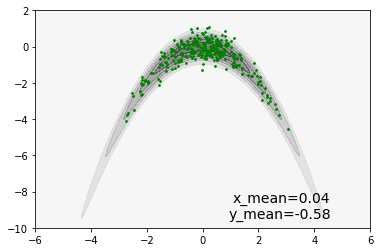

In [122]:
fig,ax=plt.subplots()
plot_contours(ax)
for i, (sample, acc) in enumerate(chain[1*len(chain)//10:10*len(chain)//10]):
    if acc and i%30==0:
#         print(sample)
#         print(x, y)
        x, y = sample[0][0][0], sample[0][1][0]
        ax.scatter(x, y, color='g', s=3)

# printing means
x_mean = np.mean([sample[0][0][0] for sample, acc in chain[1*len(chain)//10:] if acc])
y_mean = np.mean([sample[0][1][0] for sample, acc in chain[1*len(chain)//10:] if acc]) 
ax.annotate('x_mean={:.02f}\ny_mean={:.02f}'.format(x_mean, y_mean),
            xy=(0.88, 0.03), xycoords='axes fraction', fontsize=14,
             textcoords='offset points',
            ha='right', va='bottom')
print('x_mean={}, y_mean={}'.format(x_mean, y_mean))
print("last sample: ", chain[-1][0])

accept rate: 1.0


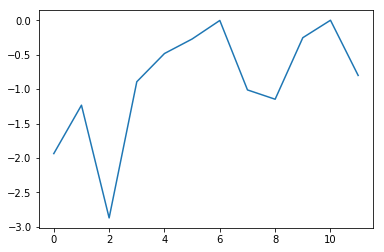

In [67]:
plt.plot(logp_array[::100])
print('accept rate:', len([1 for _, acc in chain[:] if acc])/len(chain))